# 2-2-2 Identity PC Network
Purpose: A baseline implementation to compare to.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

%load_ext autoreload
%autoreload 1
%aimport PCNetwork
%aimport PCLayer
%aimport PCConnection

np.set_printoptions(precision=4)

dtype = torch.float32
if torch.cuda.is_available():
    device = torch.device("cuda:5") # Uncomment this to run on GPU
else:
    device = torch.device("cpu")

# Dataset class

In [2]:
class SimpleDataset(Dataset):
    def __init__(self, A, B, n=300, Anoise=0.1, Bnoise=0.):
        self.samples = []
        self.n_classes = len(A)
        self.input_dim = len(A[0])
        for i in range(n):
            r = np.random.randint(self.n_classes)
            sample = [A[r]+Anoise*torch.randn_like(A[r]), B[r]+Bnoise*torch.randn_like(B[r])]
            #sample = [A[r]+noise*torch.randn_like(A[r]), B[r]+noise*torch.randn_like(B[r])]
            self.samples.append(sample)
        
    def __getitem__(self, idx):
        return self.samples[idx]
        
    def __len__(self):
        return len(self.samples)
    
    def Inputs(self):
        x = []
        for s in self.samples:
            x.append(s[0])
        return torch.stack(x)
    
    def Targets(self):
        t = []
        for s in self.samples:
            t.append(s[1])
        return torch.stack(t)
            
    def InputsOfClass(self, c):
        x = []
        for s in self.samples:
            if torch.argmax(s[1])==c:
                x.append(s[0])
        return torch.stack(x)
    
    def ClassMean(self):
        xmean = []
        for c_idx in range(self.n_classes):
            classmean = torch.mean(self.InputsOfClass(c_idx), axis=0)
            xmean.append(classmean)
        return torch.stack(xmean)
            
    def Plot(self, labels=[], idx=(1,2), equal=True):
        X = self.Inputs()
        if len(labels)==0:
            labels = self.Targets()
        colour_options = ['y', 'r', 'g', 'b', 'k']
        cidx = torch.argmax(labels, axis=1)
        colours = [colour_options[k] for k in cidx]
        plt.scatter(X.cpu()[:,idx[0]], X.cpu()[:,idx[1]], color=colours, marker='.')

        if equal:
            plt.axis('equal');

In [9]:
A = torch.tensor([[-1,-2],[3,4]], dtype=torch.float)
blah = SimpleDataset(A, A, n=200, Anoise=0.2, Bnoise=0.0)

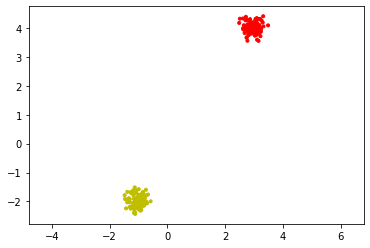

In [10]:
blah.Plot(idx=(0,1));

# Create Network

In [11]:
# 2-2-2 network
net = PCNetwork.PCNetwork(device=device)
net.AddLayer(PCLayer.PCLayer(n=2, device=device))  # [0] v0 input

net.AddLayer(PCLayer.PCLayer(n=2, device=device))  # [1] e1 error
net.AddLayer(PCLayer.PCLayer(n=2, device=device))  # [2] v1 class

net.Connect(v_idx=0, e_idx=1, type='general', sym=True, act_text='identity')
net.Connect(e_idx=1, v_idx=2, type='1to1')

net.SetTau(0.05)
net.SetGamma(0.1)

# Training

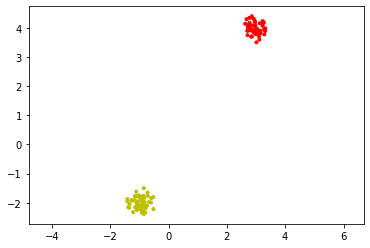

In [13]:
# Dataset
ds = SimpleDataset(A, A, n=100, Anoise=0.2, Bnoise=0.0)
dl = DataLoader(ds, batch_size=100, shuffle=True)
ds.Plot(idx=(0,1))

In [14]:
net.ClearHistory()
net.Probe(True)
net.Learning(True)

# Connection (v0)--(e1)
#net.con[0].SetIdentity() # v0-e1
net.con[0].SetRandom(random=0.1) # v0-e1

# Turn off bells and whistles
net.SetDynamicWeightDecay(0.0, 0.0)
net.SetActivityDecay(0.0)
net.SetBlackout(0.)

In [15]:
net.con[0].W

tensor([[ 0.0231, -0.1668],
        [ 0.0608, -0.0627]])

In [16]:
net.con[1].M

tensor([[1., 0.],
        [0., 1.]])

## Train it

In [17]:
net.Reset()
net.Learn(dl, T=1., epochs=10)

100%|██████████| 10/10 [00:03<00:00,  3.19it/s]


In [18]:
print(net.con[0].M)
print(net.con[0].W)

tensor([[0.7338, 0.1712],
        [0.1921, 0.8815]])
tensor([[0.7338, 0.1921],
        [0.1712, 0.8815]])


In [19]:
print(net.con[1].M)
print(net.con[1].W)

tensor([[1., 0.],
        [0., 1.]])
tensor([[1., 0.],
        [0., 1.]])


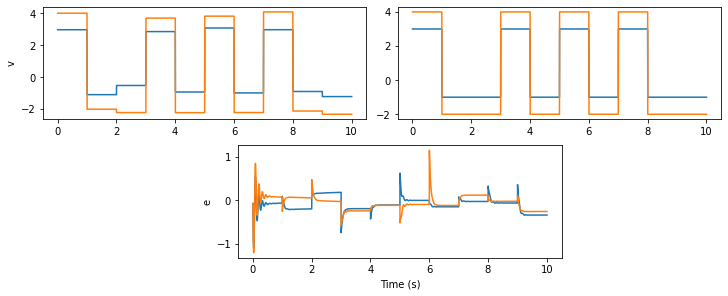

In [20]:
net.Plot();